# Various checks of model and metrics

In [1]:
import os 
import sys
import numpy as np

sys.path.append("../submissions/keras_cnns_pretrained")
sys.path.append("../")

In [2]:
from rampwf.workflows.image_classifier import BatchGeneratorBuilder

In [3]:
from image_preprocessor import transform, transform_test
from problem import get_cv, get_train_data, Predictions, score_types

## Load data and score functions with rampws

In [4]:
n_classes = 403
batch_size = 16

In [5]:
folder_X_train, y_train = get_train_data(path="..")
cv = list(get_cv(folder_X_train, y_train))

for fold_i, (train_is, valid_is) in enumerate(cv):

    folder, X_train = folder_X_train

    gen = BatchGeneratorBuilder(X_array=X_train[train_is], y_array=y_train[train_is], 
                                transform_img=transform, transform_test_img=transform_test, 
                                folder=folder, 
                                chunk_size=batch_size*5, 
                                n_classes=n_classes, n_jobs=1)
    break

In [6]:
ground_truth_train_train = Predictions(y_true=y_train[train_is])

In [7]:
score_types

In [8]:
score_types[-1].score_function(ground_truth_train_train, ground_truth_train_train)

1.0

In [9]:
def score_function(self, ground_truths, predictions, valid_indexes=None):
    self.label_names = ground_truths.label_names
    if valid_indexes is None:
        valid_indexes = slice(None, None, None)
    y_pred_label_index = predictions.y_pred_label_index[valid_indexes]
    y_true_label_index = ground_truths.y_pred_label_index[valid_indexes]
    self.check_y_pred_dimensions(y_true_label_index, y_pred_label_index)
    return self.__call__(y_true_label_index, y_pred_label_index)


In [10]:
valid_indexes = slice(None, None, None)

ground_truth_train_train.y_pred_label_index[valid_indexes]

array([159,  57,  84, ...,  35,  15,  95])

## Compare f1above, f1_score and fbeta_score (beta=1)

### Example of incorrect rare classes prediction 

In [40]:
from sklearn.metrics import f1_score, fbeta_score
from rampwf.score_types.f1_above import F1Above

In [144]:
y_true_labels = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 4, 5]
y_pred_labels = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [145]:
f1_score(y_true_labels, y_pred_labels, average=None), fbeta_score(y_true_labels, y_pred_labels, beta=1, average=None) 

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([ 1.        ,  0.72727273,  0.        ,  0.        ,  0.        ,  0.        ]),
 array([ 1.        ,  0.72727273,  0.        ,  0.        ,  0.        ,  0.        ]))

In [146]:
f1above = F1Above(threshold=0.7, precision=3)

In [147]:
f1above(y_true_labels, y_pred_labels)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.3333333333333333

### Another example 

In [114]:
nb_classes = 10

In [115]:
y_true = np.zeros((nb_classes, nb_classes), dtype=np.uint8)
for i in range(nb_classes):
    y_true[i, i] = 1
    
y_pred = np.zeros((nb_classes, nb_classes), dtype=np.uint8)
for i in range(nb_classes):
    j = np.random.randint(i-1 if i-1 >= 0 else 0, i+1 if i+1 < nb_classes else i)
    y_pred[i, j] = 1

In [116]:
print(y_true, '\n', y_pred)

[[1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]] 
 [[1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]]


In [117]:
y_true_labels = np.array([np.where(y > 0)[0] for y in y_true]).ravel()
y_pred_labels = np.array([np.where(y > 0)[0] for y in y_pred]).ravel()

In [118]:
y_pred_labels, y_true_labels

(array([0, 0, 1, 2, 4, 5, 6, 7, 7, 8]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [119]:
f1above(y_true, y_pred), f1above(y_true_labels, y_pred_labels)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.3, 0.3)

### How it is computed

In [120]:
f1above??

In [121]:
res = f1_score(y_true_labels, y_pred_labels, average=None)
res

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([ 0.66666667,  0.        ,  0.        ,  0.        ,  1.        ,
        1.        ,  1.        ,  0.66666667,  0.        ,  0.        ])

In [122]:
len(res[res>0.7]) / len(res) 

0.3

In [123]:
res = fbeta_score(y_true_labels, y_pred_labels, beta=1, average=None)
res

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([ 0.66666667,  0.        ,  0.        ,  0.        ,  1.        ,
        1.        ,  1.        ,  0.66666667,  0.        ,  0.        ])

In [124]:
len(res[res>0.7]) /  len(res) 

0.3

In [127]:
res = f1_score(y_true, y_pred, average=None)
res

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([ 0.66666667,  0.        ,  0.        ,  0.        ,  1.        ,
        1.        ,  1.        ,  0.66666667,  0.        ,  0.        ])

In [128]:
len(res[res>0.7]) / len(res) 

0.3

In [131]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support??

Compute f1 with TP, FP, FN

In [161]:
TP = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)), axis=0)
TP_FP = np.sum(np.round(np.clip(y_pred, 0, 1)), axis=0)
TP_FN = np.sum(np.round(np.clip(y_true, 0, 1)), axis=0)

In [162]:
TP, TP_FP, TP_FN

(array([1, 0, 0, 0, 1, 1, 1, 1, 0, 0], dtype=uint64),
 array([2, 1, 1, 0, 1, 1, 1, 2, 1, 0], dtype=uint64),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint64))

In [158]:
y_pred

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], dtype=uint8)

In [163]:
2.0*TP / (TP_FP + TP_FN)

array([ 0.66666667,  0.        ,  0.        ,  0.        ,  1.        ,
        1.        ,  1.        ,  0.66666667,  0.        ,  0.        ])

In [208]:
np.clip((2.0*TP / (TP_FP + TP_FN) - 0.7)*10.0, 0.0, 1.0)

array([ 0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.])

## Implement f170 metric in Keras

In [2]:
from keras import backend as K

Using TensorFlow backend.


In [209]:
def f170(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)

    numer = 2.0 * true_positives
    denom = predicted_positives + possible_positives + K.epsilon()
    f1 = numer / denom
    score = K.sum(K.round(K.clip((f1 - 0.7)*10.0, 0.0, 1)), axis=0) / K.int_shape(f1)[0]
    return f1, score

In [210]:
Y_true = K.placeholder(shape=(None, nb_classes), dtype='float32')
Y_pred = K.placeholder(shape=(None, nb_classes), dtype='float32')
f170_score = f170(Y_true, Y_pred)

In [211]:
print(y_true, '\n', y_pred)

[[1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]] 
 [[1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]]


In [212]:
sess = K.get_session()
res = sess.run(f170_score, feed_dict={Y_true: y_true, Y_pred: y_pred})

In [213]:
res

(array([ 0.66666669,  0.        ,  0.        ,  0.        ,  1.        ,
         1.        ,  1.        ,  0.66666669,  0.        ,  0.        ], dtype=float32),
 0.30000001)

## DenseNet architecture

In [8]:
!pip uninstall -y keras-contrib

Uninstalling keras-contrib-1.2.1:
  Successfully uninstalled keras-contrib-1.2.1


In [12]:
!cd ../../../ && rm -R keras-contrib

In [13]:
!cd ../../../ && git clone https://github.com/vfdev-5/keras-contrib.git -b densenet-naming && cd keras-contrib && python setup.py install

Cloning into 'keras-contrib'...
remote: Counting objects: 1643, done.
remote: Total 1643 (delta 0), reused 0 (delta 0), pack-reused 1642
Receiving objects: 100% (1643/1643), 1.40 MiB | 1.14 MiB/s, done.
Resolving deltas: 100% (1024/1024), done.
Checking connectivity... done.
running install
running bdist_egg
running egg_info
creating keras_contrib.egg-info
writing requirements to keras_contrib.egg-info/requires.txt
writing keras_contrib.egg-info/PKG-INFO
writing top-level names to keras_contrib.egg-info/top_level.txt
writing dependency_links to keras_contrib.egg-info/dependency_links.txt
writing manifest file 'keras_contrib.egg-info/SOURCES.txt'
reading manifest file 'keras_contrib.egg-info/SOURCES.txt'
writing manifest file 'keras_contrib.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib.linux-x86_64-2.7
creating build/lib.linux-x86_64-2.7/keras_contrib
copying keras_contrib/__init__.py 

byte-compiling build/bdist.linux-x86_64/egg/keras_contrib/applications/densenet.py to densenet.pyc
byte-compiling build/bdist.linux-x86_64/egg/keras_contrib/backend/__init__.py to __init__.pyc
byte-compiling build/bdist.linux-x86_64/egg/keras_contrib/backend/theano_backend.py to theano_backend.pyc
byte-compiling build/bdist.linux-x86_64/egg/keras_contrib/backend/cntk_backend.py to cntk_backend.pyc
byte-compiling build/bdist.linux-x86_64/egg/keras_contrib/backend/tensorflow_backend.py to tensorflow_backend.pyc
byte-compiling build/bdist.linux-x86_64/egg/keras_contrib/utils/__init__.py to __init__.pyc
byte-compiling build/bdist.linux-x86_64/egg/keras_contrib/utils/test_utils.py to test_utils.pyc
byte-compiling build/bdist.linux-x86_64/egg/keras_contrib/utils/save_load_utils.py to save_load_utils.pyc
byte-compiling build/bdist.linux-x86_64/egg/keras_contrib/optimizers/__init__.py to __init__.pyc
byte-compiling build/bdist.linux-x86_64/egg/keras_contrib/optimizers/ftml.py to ftml.pyc
byte-

In [1]:
from keras_contrib.applications import densenet
densenet??

Using TensorFlow backend.


In [2]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [3]:
from keras_contrib.applications.densenet import DenseNetImageNet121, DenseNetImageNet169

from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D

In [4]:
densenet = DenseNetImageNet121(include_top=False, weights='imagenet')

Weights for the model were loaded successfully


In [5]:
layers_to_train = [
    'dense_3', 
]

for l in densenet.layers:    
    l.trainable = False
    for ltt in layers_to_train:
        if ltt in l.name:
            l.trainable = True
            break    

In [6]:
for l in densenet.layers:
    print(l.name, l.trainable)

('input_1', False)
('initial_conv2D', False)
('initial_bn', False)
('activation_1', False)
('max_pooling2d_1', False)
('dense_0_0_bn', False)
('activation_2', False)
('dense_0_0_bottleneck_conv2D', False)
('dense_0_0_bottleneck_bn', False)
('activation_3', False)
('dense_0_0_conv2D', False)
('concatenate_1', False)
('dense_0_1_bn', False)
('activation_4', False)
('dense_0_1_bottleneck_conv2D', False)
('dense_0_1_bottleneck_bn', False)
('activation_5', False)
('dense_0_1_conv2D', False)
('concatenate_2', False)
('dense_0_2_bn', False)
('activation_6', False)
('dense_0_2_bottleneck_conv2D', False)
('dense_0_2_bottleneck_bn', False)
('activation_7', False)
('dense_0_2_conv2D', False)
('concatenate_3', False)
('dense_0_3_bn', False)
('activation_8', False)
('dense_0_3_bottleneck_conv2D', False)
('dense_0_3_bottleneck_bn', False)
('activation_9', False)
('dense_0_3_conv2D', False)
('concatenate_4', False)
('dense_0_4_bn', False)
('activation_10', False)
('dense_0_4_bottleneck_conv2D', False

In [7]:
inputs = Input((224, 224, 3))
x = densenet(inputs)
x = GlobalAveragePooling2D()(x)
outputs = Dense(403, activation='softmax', name='predictions')(x)
model = Model(inputs, outputs)

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
densenet (Model)             multiple                  7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
predictions (Dense)          (None, 403)               413075    
Total params: 7,450,579
Trainable params: 2,571,155
Non-trainable params: 4,879,424
_________________________________________________________________


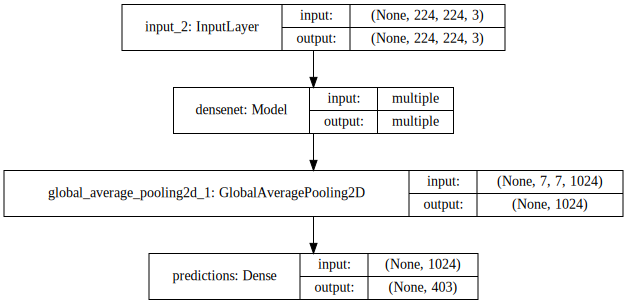

In [9]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Check whether weights persists between two compiles

In [2]:
from keras.layers import Dense, Input
from keras.models import Model
from keras import backend as K

In [3]:
K.backend()

u'tensorflow'

In [25]:
inputs = Input((5,))
x = Dense(5, activation='relu', name='h1')(inputs)
outputs = Dense(3, name='outputs', activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

In [26]:
model.get_weights()

[array([[-0.01780224, -0.74143088,  0.00864518,  0.61815393,  0.61407268],
        [-0.55116743, -0.60940349,  0.44519019,  0.73013389, -0.08439738],
        [ 0.06512403,  0.27303731,  0.43248463,  0.46034396,  0.38414681],
        [-0.4533391 , -0.16825628, -0.46597958,  0.75280452, -0.70011079],
        [ 0.25428903, -0.26853603, -0.42313313, -0.67908108,  0.12877578]], dtype=float32),
 array([ 0.,  0.,  0.,  0.,  0.], dtype=float32),
 array([[ 0.35312241, -0.56299877, -0.50557745],
        [ 0.28781694,  0.42226642, -0.55769169],
        [ 0.85733873, -0.48527521,  0.42665035],
        [-0.27444965,  0.15524584,  0.82719976],
        [ 0.09382564,  0.1313554 ,  0.46007532]], dtype=float32),
 array([ 0.,  0.,  0.], dtype=float32)]

In [27]:
import numpy as np

X_array = np.random.randn(100, 5)
y_array = np.random.randint(3, size=100)

In [28]:
from keras.utils import to_categorical

y_array_encoded = to_categorical(y_array)

In [29]:
model.compile('Adam', loss='categorical_crossentropy')

In [30]:
model.get_weights()

[array([[-0.01780224, -0.74143088,  0.00864518,  0.61815393,  0.61407268],
        [-0.55116743, -0.60940349,  0.44519019,  0.73013389, -0.08439738],
        [ 0.06512403,  0.27303731,  0.43248463,  0.46034396,  0.38414681],
        [-0.4533391 , -0.16825628, -0.46597958,  0.75280452, -0.70011079],
        [ 0.25428903, -0.26853603, -0.42313313, -0.67908108,  0.12877578]], dtype=float32),
 array([ 0.,  0.,  0.,  0.,  0.], dtype=float32),
 array([[ 0.35312241, -0.56299877, -0.50557745],
        [ 0.28781694,  0.42226642, -0.55769169],
        [ 0.85733873, -0.48527521,  0.42665035],
        [-0.27444965,  0.15524584,  0.82719976],
        [ 0.09382564,  0.1313554 ,  0.46007532]], dtype=float32),
 array([ 0.,  0.,  0.], dtype=float32)]

In [31]:
model.fit(x=X_array, y=y_array_encoded, batch_size=10, epochs=1)

Epoch 1/1
100/100 [==============================] - 0s - loss: 1.3781     


In [32]:
model.get_weights()

[array([[-0.01494108, -0.74009442,  0.01175752,  0.6186437 ,  0.61449468],
        [-0.54577154, -0.60359216,  0.43962598,  0.72248858, -0.09154109],
        [ 0.06098223,  0.27567554,  0.42897192,  0.46147454,  0.38513163],
        [-0.44542062, -0.17073084, -0.45913336,  0.75329721, -0.70088029],
        [ 0.25859812, -0.27225414, -0.41770595, -0.67719072,  0.13531844]], dtype=float32),
 array([-0.00787145,  0.00181569, -0.00850289, -0.00721043,  0.00205511], dtype=float32),
 array([[ 0.3475104 , -0.5603236 , -0.49988821],
        [ 0.28076199,  0.42587969, -0.55333209],
        [ 0.84972471, -0.47715569,  0.41955096],
        [-0.27331468,  0.16101466,  0.81992626],
        [ 0.08792495,  0.13380359,  0.46264172]], dtype=float32),
 array([-0.00469583,  0.00482583, -0.00150233], dtype=float32)]

In [33]:
model.compile('SGD', loss='categorical_crossentropy')

In [34]:
model.get_weights()

[array([[-0.01494108, -0.74009442,  0.01175752,  0.6186437 ,  0.61449468],
        [-0.54577154, -0.60359216,  0.43962598,  0.72248858, -0.09154109],
        [ 0.06098223,  0.27567554,  0.42897192,  0.46147454,  0.38513163],
        [-0.44542062, -0.17073084, -0.45913336,  0.75329721, -0.70088029],
        [ 0.25859812, -0.27225414, -0.41770595, -0.67719072,  0.13531844]], dtype=float32),
 array([-0.00787145,  0.00181569, -0.00850289, -0.00721043,  0.00205511], dtype=float32),
 array([[ 0.3475104 , -0.5603236 , -0.49988821],
        [ 0.28076199,  0.42587969, -0.55333209],
        [ 0.84972471, -0.47715569,  0.41955096],
        [-0.27331468,  0.16101466,  0.81992626],
        [ 0.08792495,  0.13380359,  0.46264172]], dtype=float32),
 array([-0.00469583,  0.00482583, -0.00150233], dtype=float32)]

In [16]:
vgg16 = VGG16(include_top=False, weights='imagenet')
inp = Input((224, 224, 3))
x = vgg16(inp)
x = Flatten(name='flatten')(x)
x = Dense(1024, activation='relu', name='fc1')(x)
x = Dropout(0.5)(x)
out = Dense(403, activation='softmax', name='predictions')(x)
model = Model(inp, out)
model.name = "VGG16"

In [17]:
fc1_layer = model.get_layer(name='fc1')

In [28]:
from keras import backend as K

sess = K.get_session()
ret = sess.run(fc1_layer.kernel)
ret[0,:10]

array([-0.00678981,  0.00369239,  0.00950394, -0.01254347,  0.00979633,
        0.00269991,  0.00692347, -0.01059241, -0.01055025, -0.01039144], dtype=float32)

In [27]:
from keras.optimizers import Adam

model.compile(
    loss='categorical_crossentropy', optimizer=Adam(lr=0.1),
    metrics=['accuracy', ])


In [29]:
from keras import backend as K

sess = K.get_session()
ret = sess.run(fc1_layer.kernel)
ret[0,:10]

array([-0.00678981,  0.00369239,  0.00950394, -0.01254347,  0.00979633,
        0.00269991,  0.00692347, -0.01059241, -0.01055025, -0.01039144], dtype=float32)